In [1]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

Samples in computational basis:
[[0 1 1 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 1 0 1]
 [0 1 1 ... 0 0 1]]

Samples in Y-basis:
[[1 1 1 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [1 1 0 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


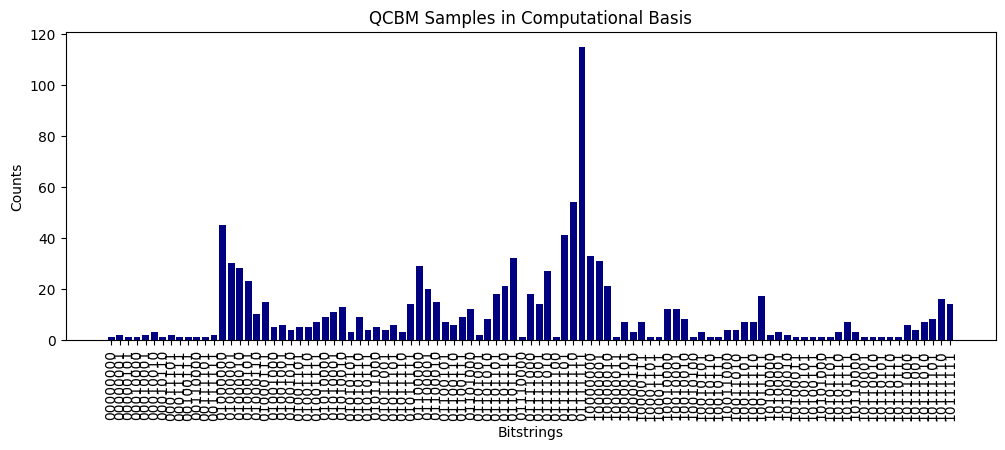

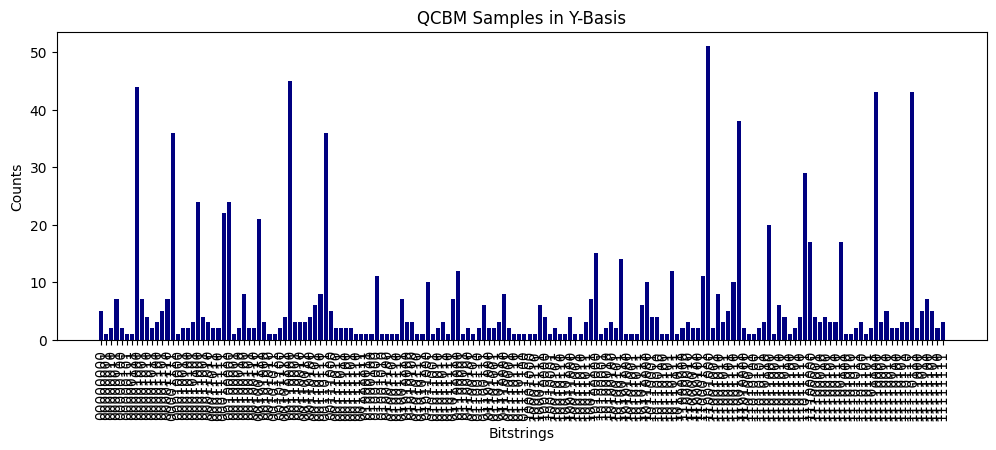

In [2]:
num_qubits = 8
num_layers = 2
num_samples = 1000

dev = qml.device("default.qubit", wires=num_qubits, shots=num_samples)

def qcbm_ansatz(params):
    param_idx = 0
    for layer in range(num_layers):

        for qubit in range(num_qubits):
            qml.RY(params[param_idx], wires=qubit)
            param_idx += 1

        for qubit in range(num_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])

# Quantum circuit definition
@qml.qnode(dev)
def circuit(params, basis="computational"):
    qcbm_ansatz(params)

    if basis == "Y":
        for qubit in range(num_qubits):
            qml.RX(np.pi / 2, wires=qubit)


    return qml.sample()

num_params = num_qubits * num_layers
params = np.random.uniform(0, 2 * np.pi, num_params)


samples_computational = circuit(params, basis="computational")
samples_Y_basis = circuit(params, basis="Y")

# Print sample outputs
print("Samples in computational basis:")
print(samples_computational)

print("\nSamples in Y-basis:")
print(samples_Y_basis)


def plot_sample_distribution(samples, title):
    counts = {}
    for sample in samples:
        bitstring = ''.join(str(int(bit)) for bit in sample)
        counts[bitstring] = counts.get(bitstring, 0) + 1

    sorted_counts = dict(sorted(counts.items()))

    plt.figure(figsize=(12, 4))
    plt.bar(sorted_counts.keys(), sorted_counts.values(), color='navy')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.show()

# Visualize results
plot_sample_distribution(samples_computational, "QCBM Samples in Computational Basis")
plot_sample_distribution(samples_Y_basis, "QCBM Samples in Y-Basis")

/opt/homebrew/lib/python3.10/site-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step 0: KL divergence = 12.0853
Step 10: KL divergence = 11.7547
Step 20: KL divergence = 12.3271
Step 30: KL divergence = 11.8746
Step 40: KL divergence = 11.8198
Step 50: KL divergence = 12.3646
Step 60: KL divergence = 11.9079
Step 70: KL divergence = 12.0120
Step 80: KL divergence = 12.1877
Step 90: KL divergence = 11.7498
Step 100: KL divergence = 11.8703
Step 110: KL divergence = 11.8275
Step 120: KL divergence = 12.4363
Step 130: KL divergence = 12.3290
Step 140: KL divergence = 12.5540
Step 150: KL divergence = 11.7653
Step 160: KL divergence = 12.1207
Step 170: KL divergence = 11.7663
Step 180: KL divergence = 12.3612
Step 190: KL divergence = 12.1973


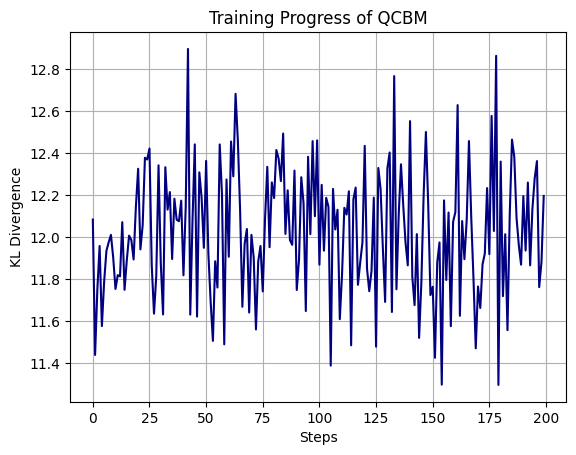

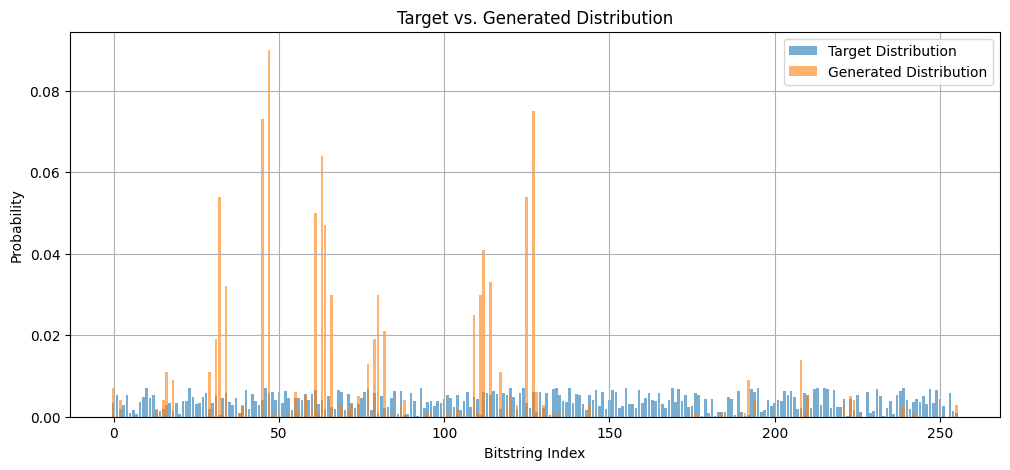

In [3]:
# Set parameters
num_qubits = 8
num_layers = 2
num_samples = 1000
steps = 200
learning_rate = 0.1

dev = qml.device("default.qubit", wires=num_qubits, shots=num_samples)

def qcbm_ansatz(params):
    param_idx = 0
    for layer in range(num_layers):
        # Rotation layer
        for qubit in range(num_qubits):
            qml.RY(params[param_idx], wires=qubit)
            param_idx += 1

        # Entangling layer (nearest-neighbor CNOTs)
        for qubit in range(num_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])


@qml.qnode(dev)
def circuit(params):
    qcbm_ansatz(params)
    return qml.probs(wires=range(num_qubits))


target_distribution = np.random.rand(2 ** num_qubits)
target_distribution /= np.sum(target_distribution)


def cost(params):
    generated_distribution = circuit(params)
    kl_divergence = np.sum(target_distribution * np.log(target_distribution / (generated_distribution + 1e-10)))
    return kl_divergence

num_params = num_qubits * num_layers
params = np.random.uniform(0, 2 * np.pi, num_params)


opt = qml.AdamOptimizer(learning_rate)

cost_progress = []
for step in range(steps):
    params, current_cost = opt.step_and_cost(cost, params)
    cost_progress.append(current_cost)
    if step % 10 == 0:
        print(f"Step {step}: KL divergence = {current_cost:.4f}")


plt.plot(cost_progress, color='navy')
plt.xlabel("Steps")
plt.ylabel("KL Divergence")
plt.title("Training Progress of QCBM")
plt.grid()
plt.show()


final_distribution = circuit(params)


plt.figure(figsize=(12, 5))
plt.bar(np.arange(2 ** num_qubits), target_distribution, alpha=0.6, label='Target Distribution')
plt.bar(np.arange(2 ** num_qubits), final_distribution, alpha=0.6, label='Generated Distribution')
plt.xlabel("Bitstring Index")
plt.ylabel("Probability")
plt.title("Target vs. Generated Distribution")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Quantum Parameters
num_qubits = 8
num_layers = 2
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

# QCBM quantum circuit ansatz
def qcbm_ansatz(params):
    idx = 0
    for _ in range(num_layers):
        for q in range(num_qubits):
            qml.RY(params[idx], wires=q)
            idx += 1
        for q in range(num_qubits - 1):
            qml.CNOT(wires=[q, q+1])

# Quantum circuit definition with probability outputs
@qml.qnode(dev, interface='torch')
def circuit(params):
    qcbm_ansatz(params)
    return qml.probs(wires=range(num_qubits))

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 1152),
            nn.BatchNorm1d(1152),
            nn.LeakyReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(1152, 128, kernel_size=3, stride=1, padding=0),  # 1x1 → 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),  # 3x3 → 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True)
        )

        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14,14 → 28,28
            nn.Tanh()  # Output range [-1,1]
        )

    def forward(self, z):
        z = self.layer1(z)
        z = z.view(-1, 1152, 1, 1)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.layer5(z)
        return z

In [6]:
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 → 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 → 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 → 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 1152, kernel_size=3, stride=1, padding=0),  # 3x3 → 1x1
            nn.BatchNorm2d(1152),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.output_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1152, latent_dim),  # Map to latent dimension (Purple "n" block)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(latent_dim, 1),  # Final output layer
            nn.Sigmoid()  # Probability output [0,1]
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)  # Process through convolutional layers (Orange)
        x = self.layer2(x)
        x = self.layer3(x)
        latent_space = self.layer4(x)
        x = self.output_layers(x)  # Process through fully connected layers (Purple)
        return x, latent_space

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

In [8]:
# Setup GAN
latent_dim = 2 ** num_qubits  # =256 for 8 qubits
img_dim = 28 * 28
lr = 0.0002
batch_size = 64
num_epochs = 50
G = Generator(latent_dim)
D = Discriminator(latent_dim)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.9))

# MNIST Data Loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

G.apply(weights_init)
D.apply(weights_init)

# Initialize QCBM parameters explicitly trainable
num_params = num_layers * num_qubits
qcbm_params = torch.nn.Parameter(torch.randn(num_params, requires_grad=True))

# Optimizer for QCBM
qcbm_optimizer = optim.Adam([qcbm_params], lr=0.1)

# Function to plot generated images - MODIFIED to display images in addition to saving
def plot_images(generator, epoch, latent_dim, num_images=16):
    """Generate, plot, and display images using the generator."""
    z_noise = torch.randn(num_images, latent_dim)
    with torch.no_grad():
        generated_imgs = generator(z_noise).view(-1, 1, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Epoch {epoch+1}')
    plt.show()
    print(f"Generated images for Epoch {epoch+1} displayed")

In [9]:
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.shape[0]
        real_imgs = real_imgs.view(batch_size, -1)

        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity, real_latent = D(real_imgs)
        real_loss = criterion(real_validity, real_labels)

        z = torch.randn(batch_size, latent_dim)  # Random noise
        fake_imgs = G(z)
        fake_validity, fake_latent = D(fake_imgs.detach())
        fake_loss = criterion(fake_validity, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train QCBM
        latent_target = torch.mean(real_latent, dim=0)
        latent_target = torch.softmax(latent_target.detach(), dim=0)
        
        qcbm_optimizer.zero_grad()
        generated_probs = circuit(qcbm_params)
        loss_qcbm = torch.sum(latent_target * torch.log((latent_target + 1e-8) / (generated_probs + 1e-8)))
        loss_qcbm.backward()
        qcbm_optimizer.step()

        with torch.no_grad():
            q_probs = circuit(qcbm_params).detach().numpy()
            q_samples = np.random.choice(np.arange(2 ** num_qubits), p=q_probs, size=batch_size)

            q_prior = np.zeros((batch_size, latent_dim), dtype=np.float32)
            q_prior[np.arange(batch_size), q_samples] = 1
            q_prior = torch.tensor(q_prior)

        # Train Generator with QCBM-informed prior
        optimizer_G.zero_grad()
        generated_imgs = G(q_prior)
        validity, _ = D(generated_imgs)
        g_loss = criterion(validity, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}, QCBM Loss: {loss_qcbm.item()}")
    with torch.no_grad():
        samples = G(q_prior).view(-1, 1, 28, 28)
        z = torch.randn(16, latent_dim)
        samples2 = G(z).view(-1, 1, 28, 28)
        grid = make_grid(samples, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.show()
        grid = make_grid(samples2, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.show()

KeyboardInterrupt: 